[...]

## Imports

In [1]:
#| echo: false

import sys
from pathlib import Path

src_path = Path('..')
sys.path.append(str(src_path.resolve()))

In [2]:
#| code-fold: true

import holidays
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import plotly.express as px
import matplotlib.pyplot as plt

import arviz as az
from scipy import stats
import statsmodels.api as sm
from great_tables import GT, nanoplot_options
from itertools import combinations
from pandas.plotting import scatter_matrix
from IPython.display import (
    display as display3,
    Markdown
)

from src.paths import get_path_to
from src.stylesheet import customize_plots
from src.inspection import make_df, display, display2

In [3]:
#| include: false
customize_plots()
# plt.style.use("_matplotlibrc")
%config InlineBackend.figure_format = 'svg'

import plotly.io as pio
# pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.renderers.default = "notebook"

## The dataset

### Load the data

We begin by exploring the data to get to know the features and patterns on which we will base our analysis.

In [4]:
#| output: false
#| warning: false
#| code-fold: true
#| code-summary: Load the data

if 'data' not in locals():
    data = pd.read_csv(
        get_path_to("data", "raw", "PBJ_Daily_Nurse_Staffing_Q1_2024.zip"),
        encoding='ISO-8859-1',
        low_memory=False
    )
else:
    print("data loaded.")

### Inspect the data

In [71]:
#| code-fold: true

GT(data.sample(5))

GT(_tbl_data=        PROVNUM                                        PROVNAME         CITY  \
239098   115600                           PRUITTHEALTH - LANIER       BUFORD   
11615    015211  TWIN OAKS REHABILITATION AND HEALTHCARE CENTER       MOBILE   
1126923  495282           LOUISA HEALTH & REHABILITATION CENTER       LOUISA   
808002   345225             SIGNATURE HEALTHCARE OF CHAPEL HILL  CHAPEL HILL   
1224851  555530         CHOWCHILLA MEMORIAL HEALTHCARE DISTRICT   CHOWCHILLA   

        STATE COUNTY_NAME  COUNTY_FIPS  CY_Qtr   WorkDate  MDScensus  \
239098     GA    Gwinnett          135  2024Q1 2024-02-11         86   
11615      AL      Mobile           97  2024Q1 2024-02-28        124   
1126923    VA      Louisa          109  2024Q1 2024-03-11         88   
808002     NC      Orange          135  2024Q1 2024-01-14         97   
1224851    CA      Madera           39  2024Q1 2024-03-23         29   

         Hrs_RNDON  ...  Hrs_LPN_ctr  Hrs_CNA  Hrs_CNA_emp  Hrs_CNA_ctr  \
239098         0.0  ...         0.00    97.00        97.00          0.0   
11615          8.0  ...         0.00   265.21       265.21          0.0   
1126923        9.5  ...         0.00   129.00       129.00          0.0   
808002         0.0  ...         7.23   185.74       185.74          0.0   
1224851        0.0  ...         0.00    73.20        73.20          0.0   

         Hrs_NAtrn  Hrs_NAtrn_emp  Hrs_NAtrn_ctr  Hrs_MedAide  \
239098         0.0            0.0            0.0         0.00   
11615          0.0            0.0            0.0         0.00   
1126923        0.0            0.0            0.0         0.00   
808002         0.0            0.0            0.0        11.99   
1224851        0.0            0.0            0.0         0.00   

         Hrs_MedAide_emp  Hrs_MedAide_ctr  
239098              0.00              0.0  
11615               0.00              0.0  
1126923             0.00              0.0  
808002             11.99              0.0  
1224851             0.00              0.0  

[5 rows x 33 columns], _body=<great_tables._gt_data.Body object at 0x2d62d9c10>, _boxhead=Boxhead([ColInfo(var='PROVNUM', type=<ColInfoTypeEnum.default: 1>, column_label='PROVNUM', column_align='right', column_width=None), ColInfo(var='PROVNAME', type=<ColInfoTypeEnum.default: 1>, column_label='PROVNAME', column_align='left', column_width=None), ColInfo(var='CITY', type=<ColInfoTypeEnum.default: 1>, column_label='CITY', column_align='left', column_width=None), ColInfo(var='STATE', type=<ColInfoTypeEnum.default: 1>, column_label='STATE', column_align='left', column_width=None), ColInfo(var='COUNTY_NAME', type=<ColInfoTypeEnum.default: 1>, column_label='COUNTY_NAME', column_align='left', column_width=None), ColInfo(var='COUNTY_FIPS', type=<ColInfoTypeEnum.default: 1>, column_label='COUNTY_FIPS', column_align='right', column_width=None), ColInfo(var='CY_Qtr', type=<ColInfoTypeEnum.default: 1>, column_label='CY_Qtr', column_align='left', column_width=None), ColInfo(var='WorkDate', type=<ColInfoTypeEnum.default: 1>, column_label='WorkDate', column_align='right', column_width=None), ColInfo(var='MDScensus', type=<ColInfoTypeEnum.default: 1>, column_label='MDScensus', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON_emp', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON_emp', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON_ctr', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON_ctr', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNadmin', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin_emp', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNadmin_emp', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin_ctr', type=<ColInfoTypeEnum.default: 1>, column

In [7]:
#| include: false
#| code-fold: true
data.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330966 entries, 0 to 1330965
Data columns (total 33 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   PROVNUM           1330966 non-null  object 
 1   PROVNAME          1330966 non-null  object 
 2   CITY              1330966 non-null  object 
 3   STATE             1330966 non-null  object 
 4   COUNTY_NAME       1330966 non-null  object 
 5   COUNTY_FIPS       1330966 non-null  int64  
 6   CY_Qtr            1330966 non-null  object 
 7   WorkDate          1330966 non-null  int64  
 8   MDScensus         1330966 non-null  int64  
 9   Hrs_RNDON         1330966 non-null  float64
 10  Hrs_RNDON_emp     1330966 non-null  float64
 11  Hrs_RNDON_ctr     1330966 non-null  float64
 12  Hrs_RNadmin       1330966 non-null  float64
 13  Hrs_RNadmin_emp   1330966 non-null  float64
 14  Hrs_RNadmin_ctr   1330966 non-null  float64
 15  Hrs_RN            1330966 non-null  float64
 16  

In [8]:
#| include: true
#| code-fold: true

df = data.describe().round(1)
GT(df.reset_index())

GT(_tbl_data=   index  COUNTY_FIPS    WorkDate  MDScensus  Hrs_RNDON  Hrs_RNDON_emp  \
0  count    1330966.0   1330966.0  1330966.0  1330966.0      1330966.0   
1   mean         91.1  20240215.7       83.4        5.2            5.1   
2    std         99.2        83.0       49.1        4.5            4.5   
3    min          1.0  20240101.0        0.0        0.0            0.0   
4    25%         31.0  20240123.0       51.0        0.0            0.0   
5    50%         69.0  20240215.0       76.0        8.0            8.0   
6    75%        117.0  20240309.0      104.0        8.0            8.0   
7    max        840.0  20240331.0      743.0      327.8          327.8   

   Hrs_RNDON_ctr  Hrs_RNadmin  Hrs_RNadmin_emp  Hrs_RNadmin_ctr  ...  \
0      1330966.0    1330966.0        1330966.0        1330966.0  ...   
1            0.1         10.3             10.0              0.2  ...   
2            0.9         14.9             14.6              1.8  ...   
3            0.0          0.0              0.0              0.0  ...   
4            0.0          0.0              0.0              0.0  ...   
5            0.0          7.5              7.4              0.0  ...   
6            0.0         16.0             16.0              0.0  ...   
7           42.0        266.2            266.2             92.5  ...   

   Hrs_LPN_ctr    Hrs_CNA  Hrs_CNA_emp  Hrs_CNA_ctr  Hrs_NAtrn  Hrs_NAtrn_emp  \
0    1330966.0  1330966.0    1330966.0    1330966.0  1330966.0      1330966.0   
1          6.5      171.2        158.2         13.0        4.2            4.2   
2         16.2      113.7        106.3         32.6       13.1           12.7   
3          0.0        0.0          0.0          0.0        0.0            0.0   
4          0.0       97.0         88.0          0.0        0.0            0.0   
5          0.0      148.1        136.8          0.0        0.0            0.0   
6          5.8      217.0        203.1         11.0        0.0            0.0   
7        454.0     1857.7       1573.1        694.3      452.0          279.0   

   Hrs_NAtrn_ctr  Hrs_MedAide  Hrs_MedAide_emp  Hrs_MedAide_ctr  
0      1330966.0    1330966.0        1330966.0        1330966.0  
1            0.1          8.5              8.3              0.2  
2            2.1         17.6             17.2              2.2  
3            0.0          0.0              0.0              0.0  
4            0.0          0.0              0.0              0.0  
5            0.0          0.0              0.0              0.0  
6            0.0         11.2             10.8              0.0  
7          280.5        395.6            395.6            128.9  

[8 rows x 28 columns], _body=<great_tables._gt_data.Body object at 0x282e18e10>, _boxhead=Boxhead([ColInfo(var='index', type=<ColInfoTypeEnum.default: 1>, column_label='index', column_align='left', column_width=None), ColInfo(var='COUNTY_FIPS', type=<ColInfoTypeEnum.default: 1>, column_label='COUNTY_FIPS', column_align='right', column_width=None), ColInfo(var='WorkDate', type=<ColInfoTypeEnum.default: 1>, column_label='WorkDate', column_align='right', column_width=None), ColInfo(var='MDScensus', type=<ColInfoTypeEnum.default: 1>, column_label='MDScensus', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON_emp', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON_emp', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON_ctr', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON_ctr', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNadmin', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin_emp', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNadmin_emp', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin_ctr', type=<ColInfoTypeEnum.default: 1>, colu

### Group the features

We note that there are 91 records per provider (`len(data["WorkDate"].unique())`) and 1,330,966 records in the table overall. The following table, which collapses the raw data across providers, thus has 14,626 $\left( \frac{1330966}{91} \right)$ entries.

In [70]:
#| include: true
#| code-fold: true
#| label: tbl-counts
#| tbl-cap: Record counts across state, country, city, and provider.

df = (
    data.loc[:, [
        "STATE",
        "COUNTY_NAME", "COUNTY_FIPS",
        "CITY",
        "PROVNAME", "PROVNUM",
    ]]
    .value_counts()
    .to_frame()
    .rename(columns={0: 'Counts'})
)
GT(df.reset_index().head())

GT(_tbl_data=  STATE COUNTY_NAME  COUNTY_FIPS       CITY  \
0    AK   Anchorage           20  ANCHORAGE   
1    OH       Allen            3       LIMA   
2    OH       Allen            3       LIMA   
3    OH       Allen            3       LIMA   
4    OH       Allen            3       LIMA   

                                    PROVNAME PROVNUM  Counts  
0  PRESTIGE CARE & REHAB CENTER OF ANCHORAGE  025025      91  
1                     LIMA CONVALESCENT HOME  366297      91  
2                              SHAWNEE MANOR  365361      91  
3                        SPRINGS OF LIMA THE  366464      91  
4                           SPRINGVIEW MANOR  366221      91  , _body=<great_tables._gt_data.Body object at 0x2dc401f50>, _boxhead=Boxhead([ColInfo(var='STATE', type=<ColInfoTypeEnum.default: 1>, column_label='STATE', column_align='left', column_width=None), ColInfo(var='COUNTY_NAME', type=<ColInfoTypeEnum.default: 1>, column_label='COUNTY_NAME', column_align='left', column_width=None), ColInfo(var='COUNTY_FIPS', type=<ColInfoTypeEnum.default: 1>, column_label='COUNTY_FIPS', column_align='right', column_width=None), ColInfo(var='CITY', type=<ColInfoTypeEnum.default: 1>, column_label='CITY', column_align='left', column_width=None), ColInfo(var='PROVNAME', type=<ColInfoTypeEnum.default: 1>, column_label='PROVNAME', column_align='left', column_width=None), ColInfo(var='PROVNUM', type=<ColInfoTypeEnum.default: 1>, column_label='PROVNUM', column_align='right', column_width=None), ColInfo(var='Counts', type=<ColInfoTypeEnum.default: 1>, column_label='Counts', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x2dc40cd50>, _spanners=Spanners([]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x2d633d690>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=Op

In [9]:
#| include: false

display2(
    "data['STATE'].value_counts()",
    "data['COUNTY_NAME'].value_counts()",
    "data['CITY'].value_counts()",
    "data['PROVNAME'].value_counts()",
    "data['MDScensus'].value_counts()",
    width="340px",
    globs=globals()
)

In [10]:
#| code-fold: true
#| tbl-column: margin
    
GT(data[["CY_Qtr", "WorkDate", "MDScensus"]].head())

GT(_tbl_data=   CY_Qtr  WorkDate  MDScensus
0  2024Q1  20240101         50
1  2024Q1  20240102         49
2  2024Q1  20240103         49
3  2024Q1  20240104         50
4  2024Q1  20240105         51, _body=<great_tables._gt_data.Body object at 0x111b88d90>, _boxhead=Boxhead([ColInfo(var='CY_Qtr', type=<ColInfoTypeEnum.default: 1>, column_label='CY_Qtr', column_align='left', column_width=None), ColInfo(var='WorkDate', type=<ColInfoTypeEnum.default: 1>, column_label='WorkDate', column_align='right', column_width=None), ColInfo(var='MDScensus', type=<ColInfoTypeEnum.default: 1>, column_label='MDScensus', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x178ee34d0>, _spanners=Spanners([]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x178ef0c10>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='heading', type='value', value='center'), heading_title_font_size=OptionsInfo(scss=True, category='heading', type='px', value='125%'), heading_title_font_weight=OptionsInfo(scss=True, categor

In [128]:
#| include: false

# Normalize feature names
# data.rename(columns=lambda name: name.replace('_', ' ').capitalize())

# Group by location for geographic view
# data.groupby(by=["STATE", "CITY"])["Hrs_NAtrn"].sum()

# Pivot date rows into columns for historical view

# Melt hrs columns into rows for professionals view
data.melt(
    value_vars=["Hrs_RN", "Hrs_LPN", "Hrs_CNA", "Hrs_NAtrn", "Hrs_MedAide"],
    var_name="Role",
    value_name="Hours"
)

# Query
# (data
#  .query("Hrs_NAtrn > 0 and STATE in ['AL', 'AZ'] and WorkDate > 20240315")
# )

# Subset feature groups
# data.filter(regex=r'^Hrs_[^_]+$', axis='columns')
# data.filter(like="Hrs_RNDON", axis="columns")

# Drop
# data.drop(columns=data.filter(regex="^CY_Qtr$").columns, inplace=False)

Role  Hours
0             Hrs_RN  40.07
1             Hrs_RN  58.89
2             Hrs_RN  55.02
3             Hrs_RN  57.13
4             Hrs_RN  46.76
...              ...    ...
6654825  Hrs_MedAide  22.70
6654826  Hrs_MedAide  17.47
6654827  Hrs_MedAide  17.94
6654828  Hrs_MedAide  14.35
6654829  Hrs_MedAide  14.62

[6654830 rows x 2 columns]

### Clean the data

In [12]:
#| code-fold: true

# Normalize feature names (lowercase and remove underscores)

# Normalize categorical features (make a column title case)
# data['CITY'].str.title()

## Explore the dataset

### Visualize distributions

### Visualize relationships

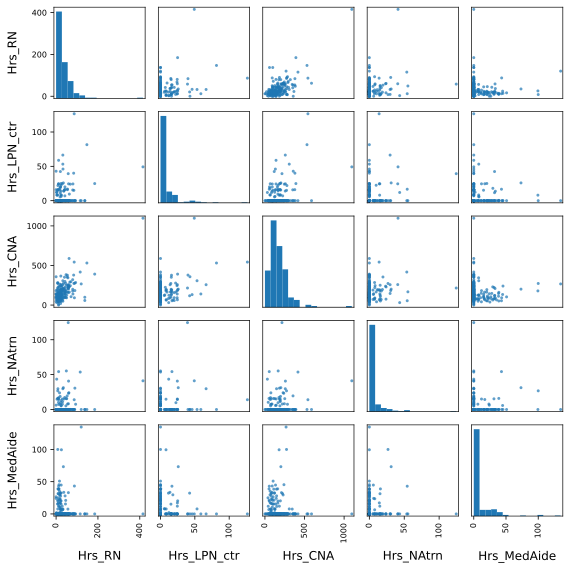

In [9]:
#| include: true
#| code-fold: true
#| label: fig-scatter-matrix
#| fig-cap: Scatter matrix of nursing worker working hours
#| column: body-outset-right

attributes = ["Hrs_RN", "Hrs_LPN_ctr", "Hrs_CNA", "Hrs_NAtrn", "Hrs_MedAide"]
n = len(attributes)

fig, axs = plt.subplots(n, n, figsize=(8, 8))
scatter_matrix(
    data[attributes].sample(200),
    ax=axs, alpha=.7,
    hist_kwds=dict(bins=15, linewidth=0)
)
fig.align_ylabels(axs[:, 0])
fig.align_xlabels(axs[-1, :])
for ax in axs.flatten():
    ax.tick_params(axis='both', which='both', length=3.5)

# save_fig("scatter_matrix_plot")

plt.show()

### Compare groups

::: {#nte-rec1 .callout-note appearance="regular"}

## [Recommendation].


:::

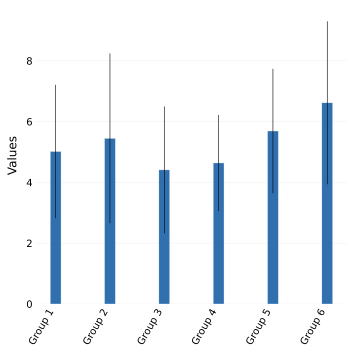

In [14]:
#| include: true
#| code-fold: true
#| label: fig-comparisons
#| fig-cap: Comparison of average nurse working hours.
#| column: body-outset-right

N_GROUPS = 6
N_LEVELS = 1

data_ = np.random.normal(loc=5, scale=3.0, size=(N_GROUPS, N_LEVELS, 10))

# Calculate averages and confidence intervals
averages = np.mean(data_, axis=2)
conf_intervals = np.zeros_like(averages, dtype=float)

for group_idx in range(N_GROUPS):
    for level_idx in range(N_LEVELS):
        interval = stats.t.interval(
            0.95,
            len(data_[group_idx, level_idx]) - 1,
            loc=np.mean(data_[group_idx, level_idx]),
            scale=stats.sem(data_[group_idx, level_idx])
        )

        # Use upper bound
        conf_intervals[group_idx, level_idx] = np.abs(
            interval[1] - averages[group_idx, level_idx]
        )

# -- Plot grouped bars with confidence intervals -----------------------------

width = 0.2
colors = plt.cm.Blues_r(np.linspace(.15, .85, N_LEVELS))
line_thickness = 0.6
stagger_amount = 0.8

fig, ax = plt.subplots()

for level_idx in range(N_LEVELS):
    bars = ax.bar(
        np.arange(N_GROUPS) + level_idx * width - (width * (N_LEVELS - 1) / 2),
        averages[:, level_idx],
        yerr=conf_intervals[:, level_idx],
        width=width,
        edgecolor="white",
        alpha=0.85,
        # capsize=3,
        color=colors[level_idx],
        error_kw={'elinewidth': line_thickness, 'capsize': 0},
        label=f'Level {level_idx + 1}',
    )

# Style
ax.set_ylabel('Values')

group_labels = [f'Group {i}' for i in range(1, N_GROUPS + 1)]
ax.set_xticks(np.arange(N_GROUPS))
ax.set_xticklabels(group_labels, rotation=60, ha='right')

# ax.legend(title='', bbox_to_anchor=(1.05, 1), loc='upper left')

# -- Add staggered sigbars and asterisks for select btwn-group comparisons ---

significance_level = 0.09
stagger_index = 0
stats_list = []

for comb in combinations(range(N_GROUPS), 2):
    group1_center = ax.get_xticks()[comb[0]]
    group2_center = ax.get_xticks()[comb[1]]

    t_stat, p_value = stats.ttest_ind(
        data_[comb[0], :, :].flatten(),
        data_[comb[1], :, :].flatten()
    )

    if p_value < significance_level:
        tallest_bar_height = np.max(averages) + np.max(conf_intervals) + 0.5

        # Adjust the stagger amount
        significance_height = (
            tallest_bar_height
            + np.max(conf_intervals) * 0.07
            + stagger_index * stagger_amount
        )

        # Plot staggered lines aligned with the midpoints of compared groups
        ax.plot(
            [group1_center, group2_center],
            [significance_height] * 2,
            color='black',
            lw=line_thickness
        )

        # Plot asterisks aligned with the center of the significance bars
        asterisks = (
            '*' * sum([p_value < alpha for alpha in [0.01, 0.001, 0.0001]])
        )
        ax.text(
            (group1_center + group2_center) / 2,
            significance_height,
            asterisks,
            ha='center',
            va='bottom',
            fontsize=10
        )

        # Increment the index for staggered bars
        stagger_index += 1

        # Store significant comparisons, t values, and sample sizes
        sample_size1 = len(data_[comb[0], :, :].flatten())
        sample_size2 = len(data_[comb[1], :, :].flatten())
        stats_list.append({
            "Comparison":
                f'{group_labels[comb[0]]} vs {group_labels[comb[1]]}',
            "p-value":
                f"{p_value:.4f}",
            "t-statistic":
                f"{t_stat:.4f}",
            "Sample Size": (
                f'{group_labels[comb[0]]} = {sample_size1}, '
                f'{group_labels[comb[1]]} = {sample_size2}'
            )
        })

# Style and show
ax.spines[['top', 'right']].set_visible(False)
ax.spines[['bottom', 'left']].set_visible(False)
ax.set_axisbelow(True)

ax.grid(axis='y')
plt.tight_layout()
plt.show()

stats_df = pd.DataFrame(stats_list)

In [15]:
#| echo: false
#| label: tbl-comparisons
#| tbl-cap: Results of group comparisons by independent t-tests.
#| layout-ncol: 1

GT(stats_df)

GT(_tbl_data=Empty DataFrame
Columns: []
Index: [], _body=<great_tables._gt_data.Body object at 0x16bcb4810>, _boxhead=Boxhead([]), _stub=<great_tables._gt_data.Stub object at 0x1698e12d0>, _spanners=Spanners([]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x1699ec8d0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_left_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_left_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_left_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), heading_background_color=OptionsInfo(scss=True, category='heading', type='value', value=None), heading_align=OptionsInfo(scss=True, category='heading', type='value', value='center'), heading_title_font_size=OptionsInfo(scss=True, category='heading', type='px', value='125%'), heading_title_font_weight=OptionsInfo(scss=True, category='heading', type='value', value='initial'), heading_subtitle_font_size=OptionsInfo(scss=True, category='heading', type='px', value='85%'), heading_subtitle_font_weight=OptionsInfo(scss=True, category='heading', type='value', value='initial'), heading_padding=OptionsInfo(scss=True, category='heading', type='px', value='4px'), heading_padding_horizontal=OptionsInfo(scss=True, category='heading', type='px', value='5px'), heading_border_bottom_style=OptionsInfo(scss=True, category='heading', type='value', value='solid'

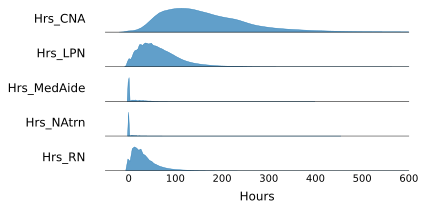

In [139]:
#| include: true
#| code-fold: true
#| label: fig-ridgeplot
#| fig-cap: Distributions of nurse working hours.
#| column: body-outset-right

df = data.copy()
df = df.melt(
    value_vars=["Hrs_RN", "Hrs_LPN", "Hrs_CNA", "Hrs_NAtrn", "Hrs_MedAide"],
    var_name="Role",
    value_name="Hours"
)

# Set up the figure and axes for subplots
num_categories = len(df["Role"].unique())
fig, axes = plt.subplots(num_categories, 1, figsize=(6, 3), sharex=True)

# Sort categories to ensure consistent order
categories = sorted(df["Role"].unique())

# Plot each category's empirical distribution in its own row
for i, category in enumerate(categories):
    ax = axes[i]
    values = df[df["Role"] == category]["Hours"].values

    # Compute HDI
    hdi = az.hdi(np.array(values), hdi_prob=0.94)
    
    # Plot KDE and HDI
    sns.kdeplot(values, ax=ax, fill=True, alpha=0.7)
    # ax.plot([hdi[0], hdi[1]], [0, 0], color="black", lw=5)
    
    ax.set_ylabel(
        category, rotation=0, labelpad=20, va="center", ha="right"
    )

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(.5)

    # ax.tick_params(axis='x', which='major', length=1.5)
    ax.yaxis.set_ticks([])
    
plt.xlim(-50, 600)
plt.xlabel("Hours")
plt.show()

## Feature engineer

### Join geographical data

In [6]:
#| output: false
#| warning: false
#| code-fold: true
#| code-summary: Load the data

if 'uscities' not in locals():
    uscities = pd.read_csv(
        get_path_to("data", "raw", "uscities", "uscities.csv"),
        encoding='ISO-8859-1',
        low_memory=False
    )
else:
    print("data loaded.")
    
GT(uscities.sample(5))

GT(_tbl_data=              city   city_ascii state_id    state_name  county_fips  \
16054    Clay City    Clay City       IL      Illinois        17025   
10615   Chinchilla   Chinchilla       PA  Pennsylvania        42069   
25846        Devol        Devol       OK      Oklahoma        40033   
1344   Kiryas Joel  Kiryas Joel       NY      New York        36071   
14073    Fairmount    Fairmount       GA       Georgia        13129   

      county_name      lat      lng  population  density source  military  \
16054        Clay  38.6858 -88.3486         883    191.4  shape     False   
10615  Lackawanna  41.4846 -75.6660        2186    336.9  shape     False   
25846      Cotton  34.1954 -98.5882         166    128.8  shape     False   
1344       Orange  41.3411 -74.1667       34368   9077.9  shape     False   
14073      Gordon  34.4383 -84.6998        1213    256.5  shape     False   

       incorporated          timezone  ranking   zips          id  
16054          True   America/Chicago        3  62824  1840010727  
10615         False  America/New_York        3  18411  1840026296  
25846          True   America/Chicago        3  73531  1840021907  
1344           True  America/New_York        2  10950  1840004872  
14073          True  America/New_York        3  30139  1840013595  , _body=<great_tables._gt_data.Body object at 0x17fa65850>, _boxhead=Boxhead([ColInfo(var='city', type=<ColInfoTypeEnum.default: 1>, column_label='city', column_align='left', column_width=None), ColInfo(var='city_ascii', type=<ColInfoTypeEnum.default: 1>, column_label='city_ascii', column_align='left', column_width=None), ColInfo(var='state_id', type=<ColInfoTypeEnum.default: 1>, column_label='state_id', column_align='left', column_width=None), ColInfo(var='state_name', type=<ColInfoTypeEnum.default: 1>, column_label='state_name', column_align='left', column_width=None), ColInfo(var='county_fips', type=<ColInfoTypeEnum.default: 1>, column_label='county_fips', column_align='right', column_width=None), ColInfo(var='county_name', type=<ColInfoTypeEnum.default: 1>, column_label='county_name', column_align='left', column_width=None), ColInfo(var='lat', type=<ColInfoTypeEnum.default: 1>, column_label='lat', column_align='right', column_width=None), ColInfo(var='lng', type=<ColInfoTypeEnum.default: 1>, column_label='lng', column_align='right', column_width=None), ColInfo(var='population', type=<ColInfoTypeEnum.default: 1>, column_label='population', column_align='right', column_width=None), ColInfo(var='density', type=<ColInfoTypeEnum.default: 1>, column_label='density', column_align='right', column_width=None), ColInfo(var='source', type=<ColInfoTypeEnum.default: 1>, column_label='source', column_align='left', column_width=None), ColInfo(var='military', type=<ColInfoTypeEnum.default: 1>, column_label='military', column_align='center', column_width=None), ColInfo(var='incorporated', type=<ColInfoTypeEnum.default: 1>, column_label='incorporated', column_align='center', column_width=None), ColInfo(var='timezone', type=<ColInfoTypeEnum.default: 1>, column_label='timezone', column_align='left', column_width=None), ColInfo(var='ranking', type=<ColInfoTypeEnum.default: 1>, column_label='ranking', column_align='right', column_width=None), ColInfo(var='zips', type=<ColInfoTypeEnum.default: 1>, column_label='zips', column_align='right', column_width=None), ColInfo(var='id', type=<ColInfoTypeEnum.default: 1>, column_label='id', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x2ac028f50>, _spanners=Spanners([]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x2ac1c5710>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsIn

In [7]:
#| output: true
#| code-fold: true
#| code-summary: Prepare the dataset to be joined

# Prepare text fields of `data`
data_ = data.copy()
data_["CITY"] = data_["CITY"].str.strip().str.title()
data_["STATE"] = data_["STATE"].str.strip().str.upper()
data_.rename(columns={"STATE": "state", "CITY": "city"}, inplace=True)
display3(GT(data_.head()))

# Prepare text fields of `uscities`
uscities['city'] = uscities['city'].str.strip().str.title()
uscities['state_id'] = uscities['state_id'].str.strip().str.upper()
display3(GT(uscities.drop(columns=["zips"]).head()))

GT(_tbl_data=  PROVNUM                  PROVNAME          city state COUNTY_NAME  \
0  015009  BURNS NURSING HOME, INC.  Russellville    AL    Franklin   
1  015009  BURNS NURSING HOME, INC.  Russellville    AL    Franklin   
2  015009  BURNS NURSING HOME, INC.  Russellville    AL    Franklin   
3  015009  BURNS NURSING HOME, INC.  Russellville    AL    Franklin   
4  015009  BURNS NURSING HOME, INC.  Russellville    AL    Franklin   

   COUNTY_FIPS  CY_Qtr  WorkDate  MDScensus  Hrs_RNDON  ...  Hrs_LPN_ctr  \
0           59  2024Q1  20240101         50        8.0  ...          0.0   
1           59  2024Q1  20240102         49        8.0  ...          0.0   
2           59  2024Q1  20240103         49        8.0  ...          0.0   
3           59  2024Q1  20240104         50        8.0  ...          0.0   
4           59  2024Q1  20240105         51        8.0  ...          0.0   

   Hrs_CNA  Hrs_CNA_emp  Hrs_CNA_ctr  Hrs_NAtrn  Hrs_NAtrn_emp  Hrs_NAtrn_ctr  \
0   156.34       156.34          0.0        0.0            0.0            0.0   
1   149.40       149.40          0.0        0.0            0.0            0.0   
2   147.15       147.15          0.0        0.0            0.0            0.0   
3   142.21       142.21          0.0        0.0            0.0            0.0   
4   149.40       149.40          0.0        0.0            0.0            0.0   

   Hrs_MedAide  Hrs_MedAide_emp  Hrs_MedAide_ctr  
0          0.0              0.0              0.0  
1          0.0              0.0              0.0  
2          0.0              0.0              0.0  
3          0.0              0.0              0.0  
4          0.0              0.0              0.0  

[5 rows x 33 columns], _body=<great_tables._gt_data.Body object at 0x2abd3f2d0>, _boxhead=Boxhead([ColInfo(var='PROVNUM', type=<ColInfoTypeEnum.default: 1>, column_label='PROVNUM', column_align='right', column_width=None), ColInfo(var='PROVNAME', type=<ColInfoTypeEnum.default: 1>, column_label='PROVNAME', column_align='left', column_width=None), ColInfo(var='city', type=<ColInfoTypeEnum.default: 1>, column_label='city', column_align='left', column_width=None), ColInfo(var='state', type=<ColInfoTypeEnum.default: 1>, column_label='state', column_align='left', column_width=None), ColInfo(var='COUNTY_NAME', type=<ColInfoTypeEnum.default: 1>, column_label='COUNTY_NAME', column_align='left', column_width=None), ColInfo(var='COUNTY_FIPS', type=<ColInfoTypeEnum.default: 1>, column_label='COUNTY_FIPS', column_align='right', column_width=None), ColInfo(var='CY_Qtr', type=<ColInfoTypeEnum.default: 1>, column_label='CY_Qtr', column_align='left', column_width=None), ColInfo(var='WorkDate', type=<ColInfoTypeEnum.default: 1>, column_label='WorkDate', column_align='right', column_width=None), ColInfo(var='MDScensus', type=<ColInfoTypeEnum.default: 1>, column_label='MDScensus', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON_emp', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON_emp', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON_ctr', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON_ctr', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNadmin', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin_emp', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNadmin_emp', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin_ctr', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNadmin_ctr', column_align='right', column_width=None), ColInfo(var='Hrs_RN', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RN', column_align='right', column_width=None), ColInfo(var='Hrs_RN_emp', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RN_emp', column_align='right', column_width=None), ColInfo(var='Hrs_RN_ctr

GT(_tbl_data=          city   city_ascii state_id  state_name  county_fips  county_name  \
0     New York     New York       NY    New York        36081       Queens   
1  Los Angeles  Los Angeles       CA  California         6037  Los Angeles   
2      Chicago      Chicago       IL    Illinois        17031         Cook   
3        Miami        Miami       FL     Florida        12086   Miami-Dade   
4      Houston      Houston       TX       Texas        48201       Harris   

       lat       lng  population  density source  military  incorporated  \
0  40.6943  -73.9249    18908608  11080.3  shape     False          True   
1  34.1141 -118.4068    11922389   3184.7  shape     False          True   
2  41.8375  -87.6866     8497759   4614.5  shape     False          True   
3  25.7840  -80.2101     6080145   4758.9  shape     False          True   
4  29.7860  -95.3885     5970127   1384.0  shape     False          True   

              timezone  ranking          id  
0     America/New_York        1  1840034016  
1  America/Los_Angeles        1  1840020491  
2      America/Chicago        1  1840000494  
3     America/New_York        1  1840015149  
4      America/Chicago        1  1840020925  , _body=<great_tables._gt_data.Body object at 0x2910ff750>, _boxhead=Boxhead([ColInfo(var='city', type=<ColInfoTypeEnum.default: 1>, column_label='city', column_align='left', column_width=None), ColInfo(var='city_ascii', type=<ColInfoTypeEnum.default: 1>, column_label='city_ascii', column_align='left', column_width=None), ColInfo(var='state_id', type=<ColInfoTypeEnum.default: 1>, column_label='state_id', column_align='left', column_width=None), ColInfo(var='state_name', type=<ColInfoTypeEnum.default: 1>, column_label='state_name', column_align='left', column_width=None), ColInfo(var='county_fips', type=<ColInfoTypeEnum.default: 1>, column_label='county_fips', column_align='right', column_width=None), ColInfo(var='county_name', type=<ColInfoTypeEnum.default: 1>, column_label='county_name', column_align='left', column_width=None), ColInfo(var='lat', type=<ColInfoTypeEnum.default: 1>, column_label='lat', column_align='right', column_width=None), ColInfo(var='lng', type=<ColInfoTypeEnum.default: 1>, column_label='lng', column_align='right', column_width=None), ColInfo(var='population', type=<ColInfoTypeEnum.default: 1>, column_label='population', column_align='right', column_width=None), ColInfo(var='density', type=<ColInfoTypeEnum.default: 1>, column_label='density', column_align='right', column_width=None), ColInfo(var='source', type=<ColInfoTypeEnum.default: 1>, column_label='source', column_align='left', column_width=None), ColInfo(var='military', type=<ColInfoTypeEnum.default: 1>, column_label='military', column_align='center', column_width=None), ColInfo(var='incorporated', type=<ColInfoTypeEnum.default: 1>, column_label='incorporated', column_align='center', column_width=None), ColInfo(var='timezone', type=<ColInfoTypeEnum.default: 1>, column_label='timezone', column_align='left', column_width=None), ColInfo(var='ranking', type=<ColInfoTypeEnum.default: 1>, column_label='ranking', column_align='right', column_width=None), ColInfo(var='id', type=<ColInfoTypeEnum.default: 1>, column_label='id', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x2914d7cd0>, _spanners=Spanners([]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x2914db410>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', va

In [16]:
#| include: false
uscities.query(expr="city == 'Russellville'")

city    city_ascii state_id      state_name  county_fips  \
1579   Russellville  Russellville       AR        Arkansas         5115   
3812   Russellville  Russellville       AL         Alabama         1059   
5207   Russellville  Russellville       KY        Kentucky        21141   
16106  Russellville  Russellville       MO        Missouri        29051   
16305  Russellville  Russellville       TN       Tennessee        47063   
17835  Russellville  Russellville       OH            Ohio        39015   
21251  Russellville  Russellville       IN         Indiana        18133   
23179  Russellville  Russellville       SC  South Carolina        45015   
28518  Russellville  Russellville       IL        Illinois        17101   

      county_name      lat      lng  population  density source  military  \
1579         Pope  35.2762 -93.1383       28946    394.9  shape     False   
3812     Franklin  34.5055 -87.7283       10767    310.0  shape     False   
5207        Logan  36.8394 -86.8950        7186    255.2  shape     False   
16106        Cole  38.5127 -92.4385         876    423.3  shape     False   
16305     Hamblen  36.2580 -83.1966         850    315.9  shape     False   
17835       Brown  38.8674 -83.7879         672    355.7  shape     False   
21251      Putnam  39.8569 -86.9833         391    236.2  shape     False   
23179    Berkeley  33.3970 -79.9637         280     28.9  shape     False   
28518    Lawrence  38.8189 -87.5300          74     71.5  shape     False   

       incorporated                      timezone  ranking               zips  \
1579           True               America/Chicago        3  72802 72801 72811   
3812           True               America/Chicago        3        35654 35653   
5207           True               America/Chicago        3              42276   
16106          True               America/Chicago        3              65074   
16305         False              America/New_York        3        37860 37891   
17835          True              America/New_York        3              45168   
21251          True  America/Indiana/Indianapolis        3              46175   
23179         False              America/New_York        3        29479 29476   
28518          True               America/Chicago        3              62439   

               id  
1579   1840014541  
3812   1840004247  
5207   1840014401  
16106  1840009797  
16305  1840036094  
17835  1840012721  
21251  1840010595  
23179  1840026993  
28518  1840012832

In [11]:
#| code-fold: true
#| code-summary: Join the datasets

# Join
data_geo = data_.merge(
    uscities[['city', 'lat', 'lng', 'population', 'state_id', 'state_name']],
    how='left',
    left_on=['city', 'state'],
    right_on=['city', 'state_id']
).drop(columns=['state_id'])

GT(data_geo.head())

GT(_tbl_data=  PROVNUM                  PROVNAME          city state COUNTY_NAME  \
0  015009  BURNS NURSING HOME, INC.  Russellville    AL    Franklin   
1  015009  BURNS NURSING HOME, INC.  Russellville    AL    Franklin   
2  015009  BURNS NURSING HOME, INC.  Russellville    AL    Franklin   
3  015009  BURNS NURSING HOME, INC.  Russellville    AL    Franklin   
4  015009  BURNS NURSING HOME, INC.  Russellville    AL    Franklin   

   COUNTY_FIPS  CY_Qtr  WorkDate  MDScensus  Hrs_RNDON  ...  Hrs_NAtrn  \
0           59  2024Q1  20240101         50        8.0  ...        0.0   
1           59  2024Q1  20240102         49        8.0  ...        0.0   
2           59  2024Q1  20240103         49        8.0  ...        0.0   
3           59  2024Q1  20240104         50        8.0  ...        0.0   
4           59  2024Q1  20240105         51        8.0  ...        0.0   

   Hrs_NAtrn_emp  Hrs_NAtrn_ctr  Hrs_MedAide  Hrs_MedAide_emp  \
0            0.0            0.0          0.0              0.0   
1            0.0            0.0          0.0              0.0   
2            0.0            0.0          0.0              0.0   
3            0.0            0.0          0.0              0.0   
4            0.0            0.0          0.0              0.0   

   Hrs_MedAide_ctr      lat      lng  population  state_name  
0              0.0  34.5055 -87.7283     10767.0     Alabama  
1              0.0  34.5055 -87.7283     10767.0     Alabama  
2              0.0  34.5055 -87.7283     10767.0     Alabama  
3              0.0  34.5055 -87.7283     10767.0     Alabama  
4              0.0  34.5055 -87.7283     10767.0     Alabama  

[5 rows x 37 columns], _body=<great_tables._gt_data.Body object at 0x2e00ca810>, _boxhead=Boxhead([ColInfo(var='PROVNUM', type=<ColInfoTypeEnum.default: 1>, column_label='PROVNUM', column_align='right', column_width=None), ColInfo(var='PROVNAME', type=<ColInfoTypeEnum.default: 1>, column_label='PROVNAME', column_align='left', column_width=None), ColInfo(var='city', type=<ColInfoTypeEnum.default: 1>, column_label='city', column_align='left', column_width=None), ColInfo(var='state', type=<ColInfoTypeEnum.default: 1>, column_label='state', column_align='left', column_width=None), ColInfo(var='COUNTY_NAME', type=<ColInfoTypeEnum.default: 1>, column_label='COUNTY_NAME', column_align='left', column_width=None), ColInfo(var='COUNTY_FIPS', type=<ColInfoTypeEnum.default: 1>, column_label='COUNTY_FIPS', column_align='right', column_width=None), ColInfo(var='CY_Qtr', type=<ColInfoTypeEnum.default: 1>, column_label='CY_Qtr', column_align='left', column_width=None), ColInfo(var='WorkDate', type=<ColInfoTypeEnum.default: 1>, column_label='WorkDate', column_align='right', column_width=None), ColInfo(var='MDScensus', type=<ColInfoTypeEnum.default: 1>, column_label='MDScensus', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON_emp', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON_emp', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON_ctr', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON_ctr', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNadmin', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin_emp', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNadmin_emp', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin_ctr', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNadmin_ctr', column_align='right', column_width=None), ColInfo(var='Hrs_RN', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RN', column_align='right', column_width=None), ColInfo(var='Hrs_RN_emp', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RN_emp', column_align='right', column_width=None), ColInfo(var='Hrs_RN_ctr', type=<ColInfoTypeEnum.default: 1>

In [12]:
#| include: true
#| code-fold: true
#| code-summary: Group by city

# Sum aggregate hours columns
data_geo["total hours"] = (
    data_geo
    .filter(regex=r'^Hrs_[^_]+$', axis='columns')
    .sum(axis=1)
)

# Group hours by city (collapse across date)
data_geo_ = (
    data_geo
    .dropna()
    .groupby(by=["city"], as_index=False)
    .agg({
        "total hours": "sum",
        "state_name": "first",
        "lat": "first",
        "lng": "first",
        "population": "first"
    })
    .rename(columns={"total hours": "total_hours_sum"})
)

GT(data_geo_.head())

GT(_tbl_data=         city  total_hours_sum   state_name      lat      lng  population
0   Abbeville        143843.65      Alabama  31.5664 -85.2528      2309.0
1  Abbotsford         18874.74    Wisconsin  44.9435 -90.3174      2186.0
2    Aberdeen        179853.83  Mississippi  33.8287 -88.5539      4972.0
3     Abilene        250997.54       Kansas  38.9230 -97.2252      6489.0
4    Abingdon         63043.01     Virginia  36.7090 -81.9713      8346.0, _body=<great_tables._gt_data.Body object at 0x2e00cbed0>, _boxhead=Boxhead([ColInfo(var='city', type=<ColInfoTypeEnum.default: 1>, column_label='city', column_align='left', column_width=None), ColInfo(var='total_hours_sum', type=<ColInfoTypeEnum.default: 1>, column_label='total_hours_sum', column_align='right', column_width=None), ColInfo(var='state_name', type=<ColInfoTypeEnum.default: 1>, column_label='state_name', column_align='left', column_width=None), ColInfo(var='lat', type=<ColInfoTypeEnum.default: 1>, column_label='lat', column_align='right', column_width=None), ColInfo(var='lng', type=<ColInfoTypeEnum.default: 1>, column_label='lng', column_align='right', column_width=None), ColInfo(var='population', type=<ColInfoTypeEnum.default: 1>, column_label='population', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x17f838750>, _spanners=Spanners([]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x293814750>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_bottom_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_bottom_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_bottom_color=OptionsInfo(scss=True, category='table', type='value', 

In [52]:
#| include: true
#| code-fold: true
#| column: screen
#| label: fig-geo
#| fig-cap: Hours worked by US city, represented by point size and colour.

gdf = gpd.GeoDataFrame(
    data_geo_,
    geometry=gpd.points_from_xy(data_geo_["lng"], data_geo_["lat"])
)

# Load a world map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Plot the map in the background
fig, ax = plt.subplots(figsize=(8, 6))
world.plot(ax=ax, color="white")

# ?Normalize the hours for color mapping
norm = plt.Normalize(
    vmin=gdf["total_hours_sum"].min(),
    vmax=gdf["total_hours_sum"].max()
)
cmap = plt.cm.jet

# Plot the cities on top of the US map, color and size by total_hours_sum
gdf.plot(
    ax=ax,
    # ?
    color=gdf["total_hours_sum"].apply(lambda x: cmap(norm(x))),
    # markersize=gdf["total_hours_sum"] / 200000,
    markersize=gdf["population"] / 200000,
    alpha=0.6
)

# Add labels to top 5 cities by total hours
top_cities = gdf.nlargest(5, "total_hours_sum")
for x, y, label in zip(
    top_cities.geometry.x, top_cities.geometry.y, top_cities["city"]
):
    ax.text(x, y, label, fontsize=8, fontweight=200, ha="right")

# Colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, shrink=0.5)
cbar.ax.tick_params(labelsize=8)
cbar.set_label("Total Hours", fontsize=8)

# Focus on the US longitude/latitude range
plt.xlim([-130, -65])
plt.ylim([20, 50])

ax.set_axis_off()
plt.show()

In [ ]:
#| include: true
#| code-fold: true
#| column: body-outset-right
##| label: fig-geo2
##| fig-cap: Hours worked by US city, represented by point size and colour.

# pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.renderers.default = "notebook"

# Plotly Express scatter_geo plot
fig = px.scatter_geo(
    data_geo_,
    lon='lng',
    lat='lat',
    # text='city',
    size='population',
    color='total_hours_sum',
    hover_name='city',
    hover_data={'total_hours_sum': True, 'population': True},
    color_continuous_scale='Jet',
    projection='natural earth'
)

# Customize layout, focusing on USA
fig.update_layout(
    title='Hours worked by US city',
    geo=dict(
        scope='usa',
        projection_type='albers usa', 
        showland=True,
        landcolor='white',
        subunitcolor="black",
        countrycolor="black",
        coastlinecolor="black",
        visible=True
    ),
    dragmode=False,
)

fig.show()

### Join seasonal data

In [8]:
#| include: true
#| code-fold: true
#| code-summary: Join the datasets

def add_time_features(df):
    df['is_weekend'] = df.index.weekday >= 5
    df['day_of_year'] = df.index.dayofyear
    
    us_holidays = holidays.US()
    df['is_holiday'] = df.index.isin(us_holidays)
    
    # df['day_index'] = np.arange(len(df))
    # return df[['day_of_year', 'day_index', 'is_weekend', 'is_holiday']]
    return df

data__ = data.copy()
data__['WorkDate'] = pd.to_datetime(data__['WorkDate'], format='%Y%m%d')
data__.set_index('WorkDate', inplace=True)

GT(add_time_features(data__).head())

GT(_tbl_data=           PROVNUM                  PROVNAME          CITY STATE COUNTY_NAME  \
WorkDate                                                                       
2024-01-01  015009  BURNS NURSING HOME, INC.  RUSSELLVILLE    AL    Franklin   
2024-01-02  015009  BURNS NURSING HOME, INC.  RUSSELLVILLE    AL    Franklin   
2024-01-03  015009  BURNS NURSING HOME, INC.  RUSSELLVILLE    AL    Franklin   
2024-01-04  015009  BURNS NURSING HOME, INC.  RUSSELLVILLE    AL    Franklin   
2024-01-05  015009  BURNS NURSING HOME, INC.  RUSSELLVILLE    AL    Franklin   

            COUNTY_FIPS  CY_Qtr  MDScensus  Hrs_RNDON  Hrs_RNDON_emp  ...  \
WorkDate                                                              ...   
2024-01-01           59  2024Q1         50        8.0            8.0  ...   
2024-01-02           59  2024Q1         49        8.0            8.0  ...   
2024-01-03           59  2024Q1         49        8.0            8.0  ...   
2024-01-04           59  2024Q1         50        8.0            8.0  ...   
2024-01-05           59  2024Q1         51        8.0            8.0  ...   

            Hrs_CNA_ctr  Hrs_NAtrn  Hrs_NAtrn_emp  Hrs_NAtrn_ctr  Hrs_MedAide  \
WorkDate                                                                        
2024-01-01          0.0        0.0            0.0            0.0          0.0   
2024-01-02          0.0        0.0            0.0            0.0          0.0   
2024-01-03          0.0        0.0            0.0            0.0          0.0   
2024-01-04          0.0        0.0            0.0            0.0          0.0   
2024-01-05          0.0        0.0            0.0            0.0          0.0   

            Hrs_MedAide_emp  Hrs_MedAide_ctr  is_weekend  day_of_year  \
WorkDate                                                                
2024-01-01              0.0              0.0       False            1   
2024-01-02              0.0              0.0       False            2   
2024-01-03              0.0              0.0       False            3   
2024-01-04              0.0              0.0       False            4   
2024-01-05              0.0              0.0       False            5   

            is_holiday  
WorkDate                
2024-01-01       False  
2024-01-02       False  
2024-01-03       False  
2024-01-04       False  
2024-01-05       False  

[5 rows x 35 columns], _body=<great_tables._gt_data.Body object at 0x2abe34250>, _boxhead=Boxhead([ColInfo(var='PROVNUM', type=<ColInfoTypeEnum.default: 1>, column_label='PROVNUM', column_align='right', column_width=None), ColInfo(var='PROVNAME', type=<ColInfoTypeEnum.default: 1>, column_label='PROVNAME', column_align='left', column_width=None), ColInfo(var='CITY', type=<ColInfoTypeEnum.default: 1>, column_label='CITY', column_align='left', column_width=None), ColInfo(var='STATE', type=<ColInfoTypeEnum.default: 1>, column_label='STATE', column_align='left', column_width=None), ColInfo(var='COUNTY_NAME', type=<ColInfoTypeEnum.default: 1>, column_label='COUNTY_NAME', column_align='left', column_width=None), ColInfo(var='COUNTY_FIPS', type=<ColInfoTypeEnum.default: 1>, column_label='COUNTY_FIPS', column_align='right', column_width=None), ColInfo(var='CY_Qtr', type=<ColInfoTypeEnum.default: 1>, column_label='CY_Qtr', column_align='left', column_width=None), ColInfo(var='MDScensus', type=<ColInfoTypeEnum.default: 1>, column_label='MDScensus', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON_emp', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON_emp', column_align='right', column_width=None), ColInfo(var='Hrs_RNDON_ctr', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNDON_ctr', column_align='right', column_width=None), ColInfo(var='Hrs_RNadmin', type=<ColInfoTypeEnum.default: 1>, column_label='Hrs_RNadmin', column_align='right', column_width=None), Co

## Analyze geography

## Analyze seasonality

In [6]:
#| include: true
#| output: false
#| code-fold: true
#| code-summary: Group by state, pivot on date and sum hours

df = data.copy()

hours_columns = [
    'Hrs_RNDON', 'Hrs_RNadmin', 'Hrs_LPNadmin',
    'Hrs_CNA', 'Hrs_NAtrn', 'Hrs_MedAide'
]

# Sum hours across positions
df['Total_Hours'] = df[hours_columns].sum(axis=1)

# Create a list of total hours per state over the work dates
city_hours = (
    df.groupby(['STATE', 'WorkDate'])['Total_Hours']
    .sum()
    .reset_index()
)

# Pivot to create lists of total hours for each state
pivoted_city_hours = city_hours.pivot_table(
    index=['STATE'],
    columns='WorkDate',
    values='Total_Hours',
    aggfunc='sum',
    fill_value=0
)

# Create a new column with lists of total hours over the 91 days
pivoted_city_hours['timeline'] = pivoted_city_hours.apply(
    lambda row: {'val': row.tolist()}, axis=1
)
pivoted_city_hours['avg'] = pivoted_city_hours.iloc[:, :-1].apply(
    lambda row: row.mean(), axis=1
)

# Prepare the DataFrame for gt
gt_df = pivoted_city_hours.reset_index()[['STATE', 'avg', 'timeline']]
# gt_df_lines = gt_df.drop(columns=['avg'])
# gt_df_avg   = gt_df.drop(columns=['lines'])

# Create a line plot for total hours trajectory by state
# gt_df['bars'] = gt_df['lines']

gt_df.head()


WorkDate STATE            avg  \
0           AK    2713.815604   
1           AL   56881.769890   
2           AR   48081.260549   
3           AZ   28998.830879   
4           CA  271155.534835   

WorkDate                                           timeline  
0         {'val': [2207.94, 2712.93, 2761.5499999999997,...  
1         {'val': [48104.89, 58689.2, 61364.25, 61429.5,...  
2         {'val': [42257.44, 51400.62, 53068.8, 53019.07...  
3         {'val': [25315.55, 29657.54, 30869.61, 31035.9...  
4         {'val': [240612.74, 272889.84, 278436.09, 2814...

In [ ]:
#| label: fig-sparklines
#| fig-cap: Sparklines of average work hours across 91 days by state.
#| code-fold: true

# Plot sparklines of average work hours across 91 days by state
(
    # GT(gt_df.head(), rowname_col="STATE")
    GT(gt_df.sort_values(by="avg", ascending=False).head(10))
    .fmt_nanoplot(
        columns="avg",
    )
    .fmt_nanoplot(
        columns="timeline",
        # plot_type="bar",
        # reference_line="mean",
        # reference_area=["min", "q1"],
        autoscale=True,
        # expand_x=[5, 16],
        # expand_y=[0, 2],
        options=nanoplot_options(
            data_point_radius=3,
            data_point_stroke_color="gray",
            data_point_stroke_width=1,
            # data_point_fill_color="white",
            data_line_type="curve",
            # data_line_stroke_color="brown",
            # data_line_stroke_width=2,
            # data_area_fill_color="orange",
            # vertical_guide_stroke_color="green",
            # show_data_area=True,
            show_data_line=False
        )
    )
    .tab_header(
        title="Nurse hours worked in the United States",
        subtitle="The top 5 busiest states",
    )
    # .tab_stubhead(label="State")
    .cols_label(
        STATE="State",
        avg="Daily average hours worked",
        timeline="Trajectory over 91 days",
    )
)

GT(_tbl_data=WorkDate STATE            avg  \
4           CA  271155.534835   
34          NY  228367.050440   
44          TX  187796.329670   
9           FL  187430.120879   
35          OH  155566.257473   
38          PA  153358.013187   
14          IL  128904.643956   
31          NJ   96150.472747   
15          IN   89536.708901   
22          MI   87133.888022   

WorkDate                                           timeline  
4         {'val': [240612.74, 272889.84, 278436.09, 2814...  
34        {'val': [186812.7, 227259.04, 241432.07, 24215...  
44        {'val': [165582.78, 195590.59, 201139.65, 2023...  
9         {'val': [170223.34, 191730.18, 195167.66, 1956...  
35        {'val': [135375.19, 162274.89, 166212.47, 1669...  
38        {'val': [131575.21, 156593.78, 163529.89, 1631...  
14        {'val': [110829.53, 134748.74, 138863.94, 1391...  
31        {'val': [76656.94, 96074.69, 101370.4, 102357....  
15        {'val': [78035.96, 94255.13, 96433.16, 96619.0...  
22        {'val': [74083.11, 91093.42, 94723.29, 94257.4...  , _body=<great_tables._gt_data.Body object at 0x31d355750>, _boxhead=Boxhead([ColInfo(var='STATE', type=<ColInfoTypeEnum.default: 1>, column_label='State', column_align='left', column_width=None), ColInfo(var='avg', type=<ColInfoTypeEnum.default: 1>, column_label='Daily average hours worked', column_align='right', column_width=None), ColInfo(var='timeline', type=<ColInfoTypeEnum.default: 1>, column_label='Trajectory over 91 days', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x2affafa90>, _spanners=Spanners([]), _heading=Heading(title='Nurse hours worked in the United States', subtitle='The top 5 busiest states', preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x2a780e3d0>, _formats=[<great_tables._gt_data.FormatInfo object at 0x28b6e4050>, <great_tables._gt_data.FormatInfo object at 0x28b6e5190>], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss

In [ ]:
#| include: false

decomposition = sm.tsa.seasonal_decompose(
    data__["Hrs_RN"][:1000],
    model='additive',
    period=91
)
fig = decomposition.plot()
plt.show()

## Model

## Concluding thoughts

(see @nte-rec1)

<!-- ## Archive -->